# Basic Ensemble learning Method
This is a basic ensemble learning method programmed with 3 different classification models:**K - Nearest Neighbors, Naive Bayes and a Neural Network** and the coross validation for the test
The code below is focused on the following points:
- Reading the data from a given file file, set up the ensemble parameters, transform the data by applying the [PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) and train the models
- The 2-dimensions PCA plot
- The Variance explanation
- The cross validation test results per fold
- The ensemble's decision boundaries
- The ensemble's confussion matrix 
- The classification results scatter plot

### Impors section
This sections imports all the necessary libraries in order for the code to work properly

In [1]:
# Imports section
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import statistics 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,log_loss
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import random

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Defining the Ensemble class
This is the definition of the entire Ensemble class. In order to have a better control and atomization of the ensemble methods and process of learning

In [2]:
class Ensemble:
    def __init__(self):
        self.dataFrame = []
        self.nPC = 2
        self.nKNN = 2
        self.nKFolds = 5
        self.hiddenLayers = [10,15,10]
        self.activFunction = "tanh"
        self.nIterations = 2500
        self.momentum = 0.9
        self.x = []
        self.y = []
        self.pca = []
        self.principalComponents = []
        self.finalDf = []
        self.text=""
        self.nLines=0
        self.nAttributes=0
        self.nClasses=0
        self.attributesName = []
        self.data = []
        self.dataPerAttribute = []
        self.classes = []
        self.principalDf = []
        self.kn = []
        self.nb = []
        self.nn = []
        self.scores_KK = []
        self.scores_KN = []
        self.scores_NN = []
        self.split_names = []
        self.model_names =['K-Nearest Neighbors','Naive Bayes','Neural Network']
        self.eclf = []
        self.eclf_scores = []
    def setDF(self,dataFrame):
        self.dataFrame = dataFrame
    def readFile(self,filename):
        # Read the file in the format given
        self.text=""
        self.nLines=0
        self.nAttributes=0
        self.nClasses=0
        self.attributesName = []
        self.data = []
        self.dataPerAttribute = []
        self.classes = []
        try:
            with open(filename,"r") as file:
                count=0
                for line in file:
                    if count < 3:
                        if count == 0:
                            self.nLines = int(line.strip())
                        else:
                            if count == 1:
                                self.nAttributes = int(line.strip())
                                for i in range(1,self.nAttributes+1):
                                    self.attributesName.append("att"+str(i))
                                    self.dataPerAttribute.append([])
                            else:
                                if count == 2:
                                    self.nClasses = int(line.strip())
                    else:
                        split_string_S = line.strip().split(',')

                        count_split = 0
                        split_string_n = []
                        for split in split_string_S:
                            if count_split >= self.nAttributes:
                                split_string_n.append(int(split))
                            else:
                                split_string_n.append(float(split))
                            count_split += 1

                        self.data.append(split_string_n)
                        self.classes.append(split_string_n[self.nAttributes])
                        n_attribute = 0
                        for attribute in split_string_n:
                            if n_attribute >= self.nAttributes:
                                break
                            else:
                                self.dataPerAttribute[n_attribute].append(attribute)
                                n_attribute += 1
                    count += 1
                print("EOF reached")
                # Turning the data into a DataFrame python object
                columns_ =  self.attributesName[:]
                columns_.append("target")
                dataFrame = pd.DataFrame(data= self.data, columns=columns_)
                self.setDF(dataFrame)
        except FileNotFoundError:
            text="Archivo no existe"
            exit()
        finally:
            file.close()
            # print(str(nLines) + "\n")
            # print(str(nAttributes) + "\n")
            # print(str(nClasses) + "\n")
            # print(attributesName)
            # print(data)
    def transformData(self,nPC):
        self.nPC = nPC
        if self.nPC > self.nAttributes:
            print(str(self.nAttributes) + " is the maximum number of principal components")
            self.nPC = min([self.nAttributes,self.nPC])
        else:
            if self.nPC <= 0:
                print("1 is the minimum number of principal components")
                self.nPC = max([1,self.nPC])
        
        # Separating out the features
        self.x = self.dataFrame.loc[:, self.attributesName].values
        # Separating out the target
        self.y = self.dataFrame.loc[:,['target']].values
        # Standardizing the features
        self.x = StandardScaler().fit_transform(self.x)
        
        print ("Creating PCA with " + str(self.nPC) + " components")
        self.pca = PCA(n_components=self.nPC)
        self.principalComponents = self.pca.fit_transform(self.x)
        pc_names = []
        for i in range(1,self.nPC+1):
            pc_names.append("principal component "+ str(i))

        self.principalDf = pd.DataFrame(data = self.principalComponents
                     , columns = pc_names)
        self.finalDf = pd.concat([self.principalDf, self.dataFrame[['target']]], axis = 1)
    def buildModels(self,nKFolds=5,nKNN=5,hiddenLayers=[10,15,10],activFunction='tanh',nIterations=2500,momentum=0.9):
        #Building models for the Ensemble
        self.nKFolds = nKFolds
        self.nKNN = nKNN
        self.kn = KNeighborsClassifier(n_neighbors=nKNN)
        self.nb = GaussianNB()
        self.hiddenLayers = hiddenLayers
        self.activFunction = activFunction
        self.nIterations = nIterations
        self.momentum = momentum
        self.nn = MLPClassifier(hidden_layer_sizes=self.hiddenLayers,
                                solver='sgd',
                                activation=self.activFunction,
                                max_iter=self.nIterations,
                                momentum=self.momentum)
        
    def getScoreModels(self):
        self.scores_KN = cross_val_score(self.kn, self.principalComponents, self.y.ravel(), cv=self.nKFolds)
        self.scores_NB = cross_val_score(self.nb, self.principalComponents, self.y.ravel(), cv=self.nKFolds)
        self.scores_NN = cross_val_score(self.nn, self.principalComponents, self.y.ravel(), cv=self.nKFolds)
        self.split_names= []
        
        for i in range(1,self.nKFolds+1):
            self.split_names.append("Fold "+str(i))
            
        kk_df = pd.DataFrame(self.scores_KN,
                           columns=['K-Nearest Neighbors'],
                             index=self.split_names)
        nb_df = pd.DataFrame(self.scores_NB,
                           columns=['Naive Bayes'],
                             index=self.split_names)
        nn_df = pd.DataFrame(self.scores_NN,
                           columns=['Neural Network'],
                             index=self.split_names)
        avg_models = [np.mean(self.scores_KN),
                     np.mean(self.scores_NB),
                     np.mean(self.scores_NN)]
        avg_df = pd.DataFrame(avg_models,
                              columns=['Normal Cross Validation Average'],index=self.model_names)
        return kk_df,nb_df,nn_df,avg_df
    def buildEnsemble(self,vote='hard'):
        self.eclf = VotingClassifier(estimators=[('kn', self.kn), 
                                                 ('nb', self.nb), 
                                                 ('nnet', self.nn)], 
                                     voting=vote)
    def trainEnsemble(self):
        self.eclf_scores = cross_val_score(self.eclf, 
                                           self.principalComponents, 
                                           self.y.ravel(), 
                                           scoring='accuracy', 
                                           cv=self.nKFolds)
        eclf_df = pd.DataFrame(self.eclf_scores,
                           columns=['Ensemble'],
                             index=self.split_names)
        #print("Accuracy: %0.4f (+/- %0.4f)" % (eclf_scores.mean(), eclf_scores.std() * 2))
        return eclf_df,self.eclf_scores.mean(),self.eclf_scores.std()
    def plot2DimPCA(self):
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title('2 component PCA', fontsize = 20)
        targets = range(0,self.nClasses)
        targetsLabels = []
        colors_ = ['r', 'g', 'b','c','m','y','k','w']
        colors = []
        for i in targets:
            targetsLabels.append("Class "+str(i))
            colors.append(colors_[i])
        for target, color in zip(targets,colors):
            indicesToKeep = self.finalDf['target'] == target
            ax.scatter(self.finalDf.loc[indicesToKeep, 'principal component 1']
                       , self.finalDf.loc[indicesToKeep, 'principal component 2']
                       , c = color
                       , s = 50)
        ax.legend(targetsLabels)
        ax.grid()
        plt.grid()
        plt.show()
    def plotDecisionBounderies(self):
        gs = gridspec.GridSpec(2, 2)

        fig = plt.figure(figsize=(10,8))

        labels = ['K Nearest Neighbors', 'Naive Bayes', 'Neural Network', 'Ensemble']
        for clf, lab, grd in zip([self.kn, self.nb, self.nn, self.eclf],
                                 labels,
                                 itertools.product([0, 1], repeat=2)):

            x = self.finalDf.loc[:,['principal component 1','principal component 2']].values
            clf.fit(x, self.y.ravel())
            ax = plt.subplot(gs[grd[0], grd[1]])
            fig = plot_decision_regions(X=x, y=self.y.ravel(), clf=clf)
            plt.title(lab)
    def printVarianceRatio(self):
        # Variance explained
        print("-------Variance per principal component-------")
        print (self.pca.explained_variance_)
        print("-------Variance ratio per principal component-------")
        print (self.pca.explained_variance_ratio_)
        print("-------Variance ratio accumulated sum per principal component-------")
        print (self.pca.explained_variance_ratio_.cumsum())
basic_ensemble = Ensemble()

### Setting the configuration for the ensemble and intern classification models
Here the user must type the following fields to begin with the ensemble's training and testing:
- The initial data file with the specified format
- The number of principal components for the PCA
- The number of K-Folds for Cross Validation
- The value of K-Nearest Neighbors to consider
- The number of Hidden Layers for the Neural Network and the number of perceptrons for each layer
- The activation function for the Newural Network: {identity, logistic, tanh, relu}
- The number of iterations for the Neural Network
- The value of momentum for the Neural Network, a floating value between 0 and 1 inclusive

In [3]:
# Change the filename
basic_ensemble.readFile("Slice409.txt")
# Ensemble's parameters
basic_ensemble.transformData(int(input('Number of principal components:')))

folds = int(input("Enter number of K-Folds for Cross Validation: "))
neighbors = int(input("Enter value of K-Nearest Neighbors: "))
hLayers = int(input("Enter number of Hidden Layers for the Neural Network: "))
layersSize=[]
for i in range(1,hLayers+1):
    layersSize.append(int(input("Number of perceptrons for the "+str(i)+"-th layer: ")))
activationFunction=input("activation{identity, logistic, tanh, relu}: ")
epochs = int(input("Number of iterations for the Neural Network: "))
moment = float(input("Momentum for the Neural Network[0-1]: "))

basic_ensemble.buildModels(nKFolds=folds,
                           nKNN=neighbors,
                           hiddenLayers=layersSize,
                           activFunction=activationFunction,
                           nIterations=epochs,
                           momentum=moment)

d1,d2,d3,a = basic_ensemble.getScoreModels()
basic_ensemble.buildEnsemble()
e_df,e_mean,e_std = basic_ensemble.trainEnsemble()
e_df

EOF reached
Number of principal components:30
Creating PCA with 30 components
Enter number of K-Folds for Cross Validation: 5
Enter value of K-Nearest Neighbors: 5
Enter number of Hidden Layers for the Neural Network: 3
Number of perceptrons for the 1-th layer: 10
Number of perceptrons for the 2-th layer: 15
Number of perceptrons for the 3-th layer: 10
activation{identity, logistic, tanh, relu}: tanh
Number of iterations for the Neural Network: 3000
Momentum for the Neural Network[0-1]: 0.8


,Ensemble
Fold 1,0.914634
Fold 2,1.000000
Fold 3,1.000000
Fold 4,0.926829
Fold 5,0.567901


### Plotting the 2-dimension PCA data
Now we will give a visual representation of our dataset using the Principal Components Analysis

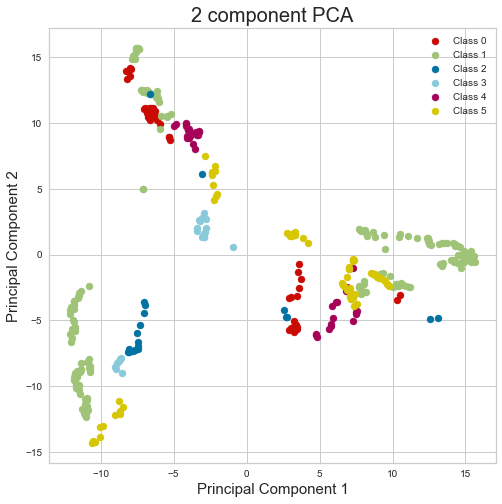

In [4]:
# Plot the 2-dimension PCA
basic_ensemble.plot2DimPCA()

### Variance explained
We print the variance per principal component in order to give a metric of how well represented our data is. 
The first array shows the variance in the data per principal component, the second one, shows for each component, the variance ratio of the entire data set that it represents, and the third and last one, shows the accumulated sum of the variance ratio in each principal component.

In [5]:
basic_ensemble.printVarianceRatio()

-------Variance per principal component-------
[80.17062523 54.52811708 38.68471015 25.34030052 19.19106307 16.84143261
 10.58892763  9.70164483  8.5802855   7.00747384  6.89898301  6.2553547
  5.30559135  4.7563029   4.59099517  4.1609927   3.94254287  3.61783276
  3.48252828  3.17701331  2.97730072  2.73986188  2.48544436  2.30595553
  2.07826138  1.99151891  1.83133556  1.79778572  1.69419437  1.59367087]
-------Variance ratio per principal component-------
[0.21326562 0.14505279 0.102907   0.06740892 0.05105104 0.04480068
 0.0281681  0.0258078  0.02282482 0.01864091 0.01835231 0.01664016
 0.01411365 0.01265246 0.01221272 0.01106885 0.01048774 0.00962397
 0.00926404 0.00845132 0.00792006 0.00728843 0.00661165 0.00613418
 0.00552848 0.00529773 0.00487162 0.00478237 0.00450681 0.0042394 ]
-------Variance ratio accumulated sum per principal component-------
[0.21326562 0.35831841 0.46122542 0.52863434 0.57968538 0.62448606
 0.65265416 0.67846196 0.70128678 0.71992769 0.73827999 0.75492

### Cross Validation results
The following section will plot the classification results for every single fold in the cross validation test

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


-----------------Fold 0--------------------


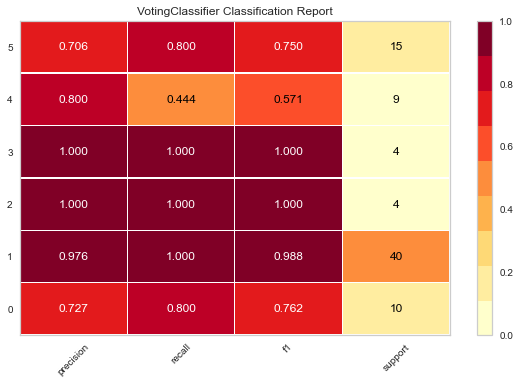

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


-----------------Fold 1--------------------


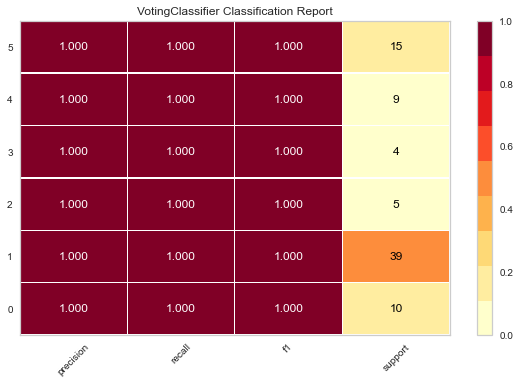

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


-----------------Fold 2--------------------


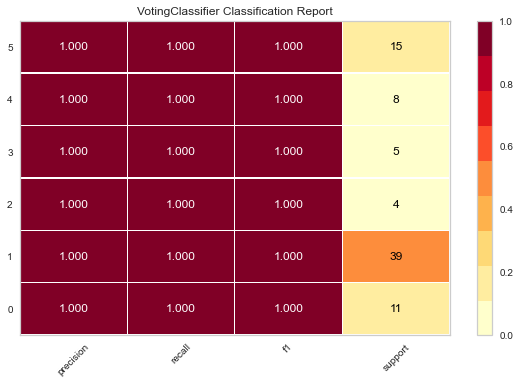

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


-----------------Fold 3--------------------


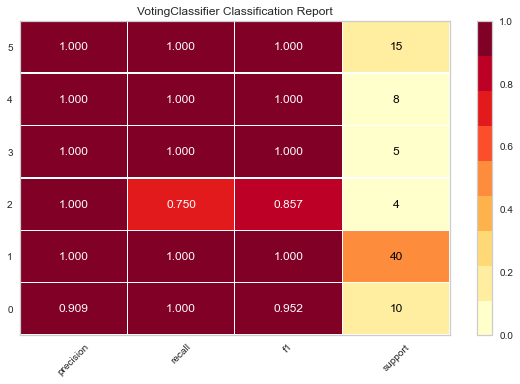

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


-----------------Fold 4--------------------


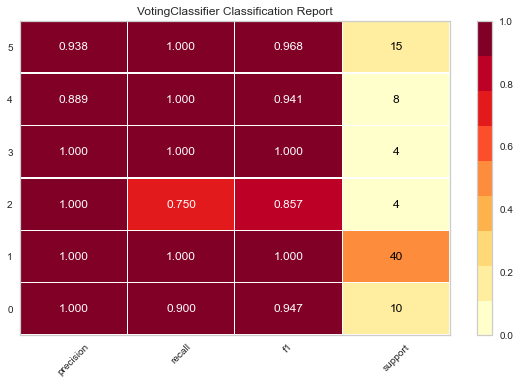

In [6]:
# Plot Classification Reports
classes = []
for i in range(0,basic_ensemble.nClasses):
    classes.append(str(i))
i = 0
KFolds = StratifiedKFold(n_splits=basic_ensemble.nKFolds)
for train_index,test_index in KFolds.split(X=basic_ensemble.principalComponents,y=basic_ensemble.y):
    X_train,X_test,y_train,y_test = basic_ensemble.principalComponents[train_index], basic_ensemble.principalComponents[test_index], basic_ensemble.y[train_index], basic_ensemble.y[test_index]
    visualizer = ClassificationReport(basic_ensemble.eclf, classes=classes, support=True)
    visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
    visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
    print("-----------------Fold "+str(i)+"--------------------")
    visualizer.show() 
    i += 1

### Decision boundaries
Now we will plot the decision boundaries for every intern classification model in the ensemble learning method and for the ensemble as well

C:\ProgramData\Miniconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
C:\ProgramData\Miniconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
C:\ProgramData\Miniconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
C:\ProgramData\Miniconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax

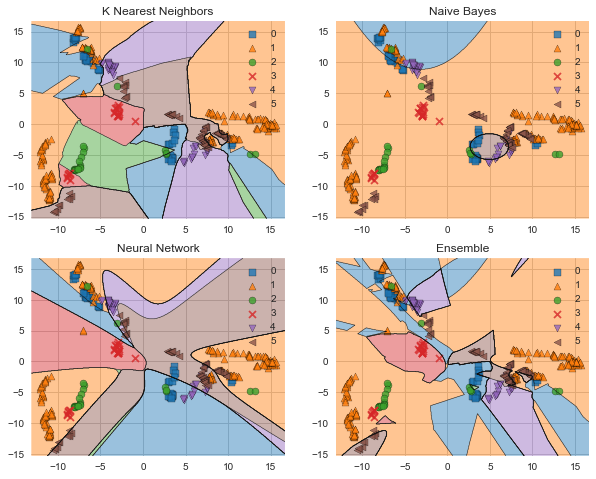

In [7]:
# Plot the ensemble and model's decision boundaries
basic_ensemble.plotDecisionBounderies()

### Confussion matrix
In order to see how well our ensemble learning method is classifying, here is plotted the ensemble's confussion matrix

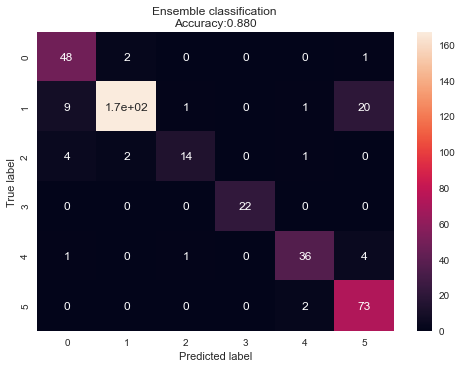

In [8]:
# Confussion matrix
y_pred = cross_val_predict(basic_ensemble.eclf, 
                           basic_ensemble.principalComponents, 
                           basic_ensemble.y.ravel(), 
                           cv=basic_ensemble.nKFolds)

# Creates a confusion matrix
cm = confusion_matrix(basic_ensemble.y.ravel(), y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Ensemble classification \nAccuracy:{0:.3f}'.format(accuracy_score(basic_ensemble.y.ravel(), y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Scatterplot of the classification results
Finally we have the classification results scatter plot to get a visual representation of the ensemble's classification process

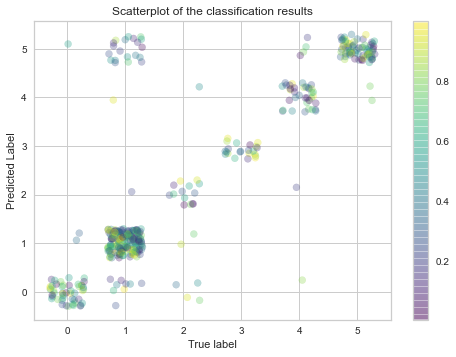

In [9]:
x_array = []
y_array = []
diff = 0.3
for i in range(0,cm.shape[0]):
    for j in range (0,cm.shape[1]):
        for c in range(0,cm[i][j]): 
            i_ = float(i)
            j_ = float(j)
            x_ = random.uniform(i_ - diff, i_ + diff)
            y_ = random.uniform(j_ - diff, j_ + diff)
            x_array.append(x_)
            y_array.append(y_)
rng = np.random.RandomState(0)
colors = rng.rand(basic_ensemble.nLines)
plt.scatter(x_array, y_array,c=colors, alpha=0.3,
            cmap='viridis')
plt.xlabel("True label")
plt.ylabel("Predicted Label");
plt.colorbar();  # show color scale
plt.title("Scatterplot of the classification results")
plt.show()